Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE

import lightgbm as lgb
import xgboost as xgb

%matplotlib inline


pd.set_option('display.max_columns', None)

Посмотрим на данные

In [2]:
c_data = pd.read_csv('output.csv')
c_data.head(5)

,user_id,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Open_Prod,Close_Prod,Total_Rel_Chng,Total_Rel_Chng_Ratio,Open_Prod_Q1,Open_Prod_Q2,Open_Prod_Q3,Open_Prod_Q4,Close_Prod_Q1,Close_Prod_Q2,Close_Prod_Q3,Close_Prod_Q4,Contacts_Count_12_mon,Total_Trans_Ct_12_mon,Trans_Ct_Q1,Trans_Ct_Q2,Trans_Ct_Q3,Trans_Ct_Q4,Total_Buy_Amt,Total_Dep_Amt
0,708134283,Existing Customer,35,M,2,Uneducated,Married,Less than $40K,Blue,36,4,2,1,5,1.25,0,1,0,1,0,1,0,0,3,85,17,23,19,26,91511,140525
1,708223383,Attrited Customer,47,F,3,High School,Married,Unknown,Blue,39,6,10,3,13,2.17,3,6,0,1,1,1,1,0,13,105,32,15,28,30,129886,143833
2,709150608,Existing Customer,30,F,0,Unknown,Married,Less than $40K,Blue,19,5,3,7,1,0.20,1,1,0,1,1,3,2,1,10,88,19,18,25,26,120259,107380
3,709814883,Existing Customer,45,F,2,High School,Single,Less than $40K,Platinum,36,1,5,5,1,1.00,1,0,2,2,4,0,0,1,10,81,16,20,15,30,82427,131794
4,709957158,Existing Customer,48,M,4,High School,Married,$40K - $60K,Blue,40,5,5,1,9,1.80,1,2,0,2,0,1,0,0,6,101,22,28,29,22,135484,123645


## Преобразование данных

Заменим категориальные признаки на дамми переменные

In [3]:
c_data.Attrition_Flag = c_data.Attrition_Flag.replace({'Attrited Customer':1,'Existing Customer':0})
c_data.Gender = c_data.Gender.replace({'F':1,'M':0})
c_data = pd.concat([c_data,pd.get_dummies(c_data['Education_Level']).drop(columns=['Unknown'])],axis=1)
c_data = pd.concat([c_data,pd.get_dummies(c_data['Marital_Status']).drop(columns=['Unknown'])],axis=1)
c_data = pd.concat([c_data,pd.get_dummies(c_data['Income_Category']).drop(columns=['Unknown'])],axis=1)
c_data = pd.concat([c_data,pd.get_dummies(c_data['Card_Category']).drop(columns=['Platinum'])],axis=1)
c_data.drop(columns = ['user_id', 'Education_Level','Income_Category','Marital_Status','Card_Category'],inplace=True)

In [4]:
c_data.head(10)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Open_Prod,Close_Prod,Total_Rel_Chng,Total_Rel_Chng_Ratio,Open_Prod_Q1,Open_Prod_Q2,Open_Prod_Q3,Open_Prod_Q4,Close_Prod_Q1,Close_Prod_Q2,Close_Prod_Q3,Close_Prod_Q4,Contacts_Count_12_mon,Total_Trans_Ct_12_mon,Trans_Ct_Q1,Trans_Ct_Q2,Trans_Ct_Q3,Trans_Ct_Q4,Total_Buy_Amt,Total_Dep_Amt,College,Doctorate,Graduate,High School,Post-Graduate,Uneducated,Divorced,Married,Single,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Blue,Gold,Silver
0,0,35,0,2,36,4,2,1,5,1.25,0,1,0,1,0,1,0,0,3,85,17,23,19,26,91511,140525,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0
1,1,47,1,3,39,6,10,3,13,2.17,3,6,0,1,1,1,1,0,13,105,32,15,28,30,129886,143833,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0,30,1,0,19,5,3,7,1,0.20,1,1,0,1,1,3,2,1,10,88,19,18,25,26,120259,107380,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
3,0,45,1,2,36,1,5,5,1,1.00,1,0,2,2,4,0,0,1,10,81,16,20,15,30,82427,131794,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
4,0,48,0,4,40,5,5,1,9,1.80,1,2,0,2,0,1,0,0,6,101,22,28,29,22,135484,123645,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0
5,0,44,0,1,33,5,2,8,-1,-0.20,0,1,1,0,1,2,3,2,10,94,25,23,27,19,132991,117589,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0
6,0,56,0,2,43,2,2,4,0,0.00,1,1,0,0,1,2,0,1,6,92,24,26,18,24,122106,129783,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
7,1,37,0,3,28,2,6,5,3,1.50,3,0,3,0,0,0,2,3,11,100,23,28,23,26,132362,112838,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
8,0,50,1,2,36,1,4,5,0,0.00,0,2,0,2,0,0,3,2,9,92,20,20,26,26,108815,102475,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0
9,0,40,1,1,30,1,5,3,3,3.00,1,2,1,1,0,0,3,0,8,108,20,27,36,25,142707,115201,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0


#### Перегенерирование целевой переменной

In [5]:
c_data.drop(columns = ['Attrition_Flag'],inplace=True)

In [6]:
c_data.groupby('Trans_Ct_Q4').Customer_Age.count()

Trans_Ct_Q4
7       1
8       1
9       2
10     13
11     12
12     30
13     78
14    104
15    141
16    272
17    375
18    451
19    577
20    692
21    739
22    823
23    829
24    773
25    807
26    743
27    625
28    485
29    393
30    347
31    247
32    177
33    130
34     87
35     72
36     43
37     29
38     10
39      9
40      4
41      5
47      1
Name: Customer_Age, dtype: int64

In [7]:
c_data.loc[(c_data['Trans_Ct_Q4'] <= 20) & (c_data['Open_Prod_Q4'] == 0) & (c_data['Close_Prod_Q4'] == 0), 'Attrition_Flag'] = 1

In [8]:
c_data.fillna(0, inplace=True)

In [9]:
c_data['Attrition_Flag'] = c_data['Attrition_Flag'].astype('uint32')

In [10]:
c_data.groupby('Attrition_Flag').Customer_Age.count()

Attrition_Flag
0    9923
1     204
Name: Customer_Age, dtype: int64

In [11]:
c_data.head()

,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Open_Prod,Close_Prod,Total_Rel_Chng,Total_Rel_Chng_Ratio,Open_Prod_Q1,Open_Prod_Q2,Open_Prod_Q3,Open_Prod_Q4,Close_Prod_Q1,Close_Prod_Q2,Close_Prod_Q3,Close_Prod_Q4,Contacts_Count_12_mon,Total_Trans_Ct_12_mon,Trans_Ct_Q1,Trans_Ct_Q2,Trans_Ct_Q3,Trans_Ct_Q4,Total_Buy_Amt,Total_Dep_Amt,College,Doctorate,Graduate,High School,Post-Graduate,Uneducated,Divorced,Married,Single,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Blue,Gold,Silver,Attrition_Flag
0,35,0,2,36,4,2,1,5,1.25,0,1,0,1,0,1,0,0,3,85,17,23,19,26,91511,140525,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0
1,47,1,3,39,6,10,3,13,2.17,3,6,0,1,1,1,1,0,13,105,32,15,28,30,129886,143833,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,30,1,0,19,5,3,7,1,0.20,1,1,0,1,1,3,2,1,10,88,19,18,25,26,120259,107380,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0
3,45,1,2,36,1,5,5,1,1.00,1,0,2,2,4,0,0,1,10,81,16,20,15,30,82427,131794,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,48,0,4,40,5,5,1,9,1.80,1,2,0,2,0,1,0,0,6,101,22,28,29,22,135484,123645,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0


## Анализ данных

Проверим, что все данные числовые и без пропусков

In [12]:
c_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              10127 non-null  int64  
 1   Gender                    10127 non-null  int64  
 2   Dependent_count           10127 non-null  int64  
 3   Months_on_book            10127 non-null  int64  
 4   Total_Relationship_Count  10127 non-null  int64  
 5   Open_Prod                 10127 non-null  int64  
 6   Close_Prod                10127 non-null  int64  
 7   Total_Rel_Chng            10127 non-null  int64  
 8   Total_Rel_Chng_Ratio      10127 non-null  float64
 9   Open_Prod_Q1              10127 non-null  int64  
 10  Open_Prod_Q2              10127 non-null  int64  
 11  Open_Prod_Q3              10127 non-null  int64  
 12  Open_Prod_Q4              10127 non-null  int64  
 13  Close_Prod_Q1             10127 non-null  int64  
 14  Close_

Посмотрим на разброс данных

In [13]:
c_data.describe()

,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Open_Prod,Close_Prod,Total_Rel_Chng,Total_Rel_Chng_Ratio,Open_Prod_Q1,Open_Prod_Q2,Open_Prod_Q3,Open_Prod_Q4,Close_Prod_Q1,Close_Prod_Q2,Close_Prod_Q3,Close_Prod_Q4,Contacts_Count_12_mon,Total_Trans_Ct_12_mon,Trans_Ct_Q1,Trans_Ct_Q2,Trans_Ct_Q3,Trans_Ct_Q4,Total_Buy_Amt,Total_Dep_Amt,College,Doctorate,Graduate,High School,Post-Graduate,Uneducated,Divorced,Married,Single,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Blue,Gold,Silver,Attrition_Flag
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,0.529081,2.346203,35.928409,3.812580,5.186334,5.159277,3.794707,1.004261,1.278167,1.301076,1.320826,1.286264,1.282611,1.288437,1.285376,1.302854,10.345611,93.456107,23.034166,23.289819,23.557520,23.574603,121948.933445,116492.739015,0.100030,0.044534,0.308877,0.198776,0.050953,0.146835,0.073862,0.462822,0.389355,0.071788,0.176755,0.138442,0.151575,0.351634,0.931767,0.011455,0.054804,0.020144
std,8.016814,0.499178,1.298908,7.986416,1.554408,2.266454,2.293584,3.542750,1.301925,1.130940,1.158188,1.144620,1.130316,1.138588,1.150895,1.139806,1.140537,3.232458,9.700432,4.800814,4.859190,4.880765,4.833137,20421.105421,19869.453633,0.300054,0.206289,0.462053,0.399098,0.219912,0.353959,0.261559,0.498641,0.487628,0.258150,0.381480,0.345380,0.358626,0.477504,0.252159,0.106416,0.227608,0.140500
min,26.000000,0.000000,0.000000,13.000000,1.000000,0.000000,0.000000,-10.000000,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,57.000000,8.000000,8.000000,8.000000,7.000000,54397.000000,47960.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,0.000000,1.000000,31.000000,3.000000,4.000000,4.000000,1.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,87.000000,20.000000,20.000000,20.000000,20.000000,107999.000000,102879.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,46.000000,1.000000,2.000000,36.000000,4.000000,5.000000,5.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,93.000000,23.000000,23.000000,23.000000,23.000000,121021.000000,116125.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,52.000000,1.000000,3.000000,40.000000,5.000000,7.000000,7.000000,6.000000,1.600000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,12.000000,100.000000,26.000000,26.000000,27.000000,27.000000,135593.500000,129370.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,73.000000,1.000000,5.000000,56.000000,6.000000,15.000000,15.000000,18.000000,9.000000,8.000000,7.000000,7.000000,8.000000,7.000000,8.000000,7.000000,8.000000,23.000000,131.000000,42.000000,43.000000,48.000000,47.000000,207378.000000,202219.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Видим, что разброс у данных сильный и надо использовать стандартизацию признаков

Построим матрику корреляции

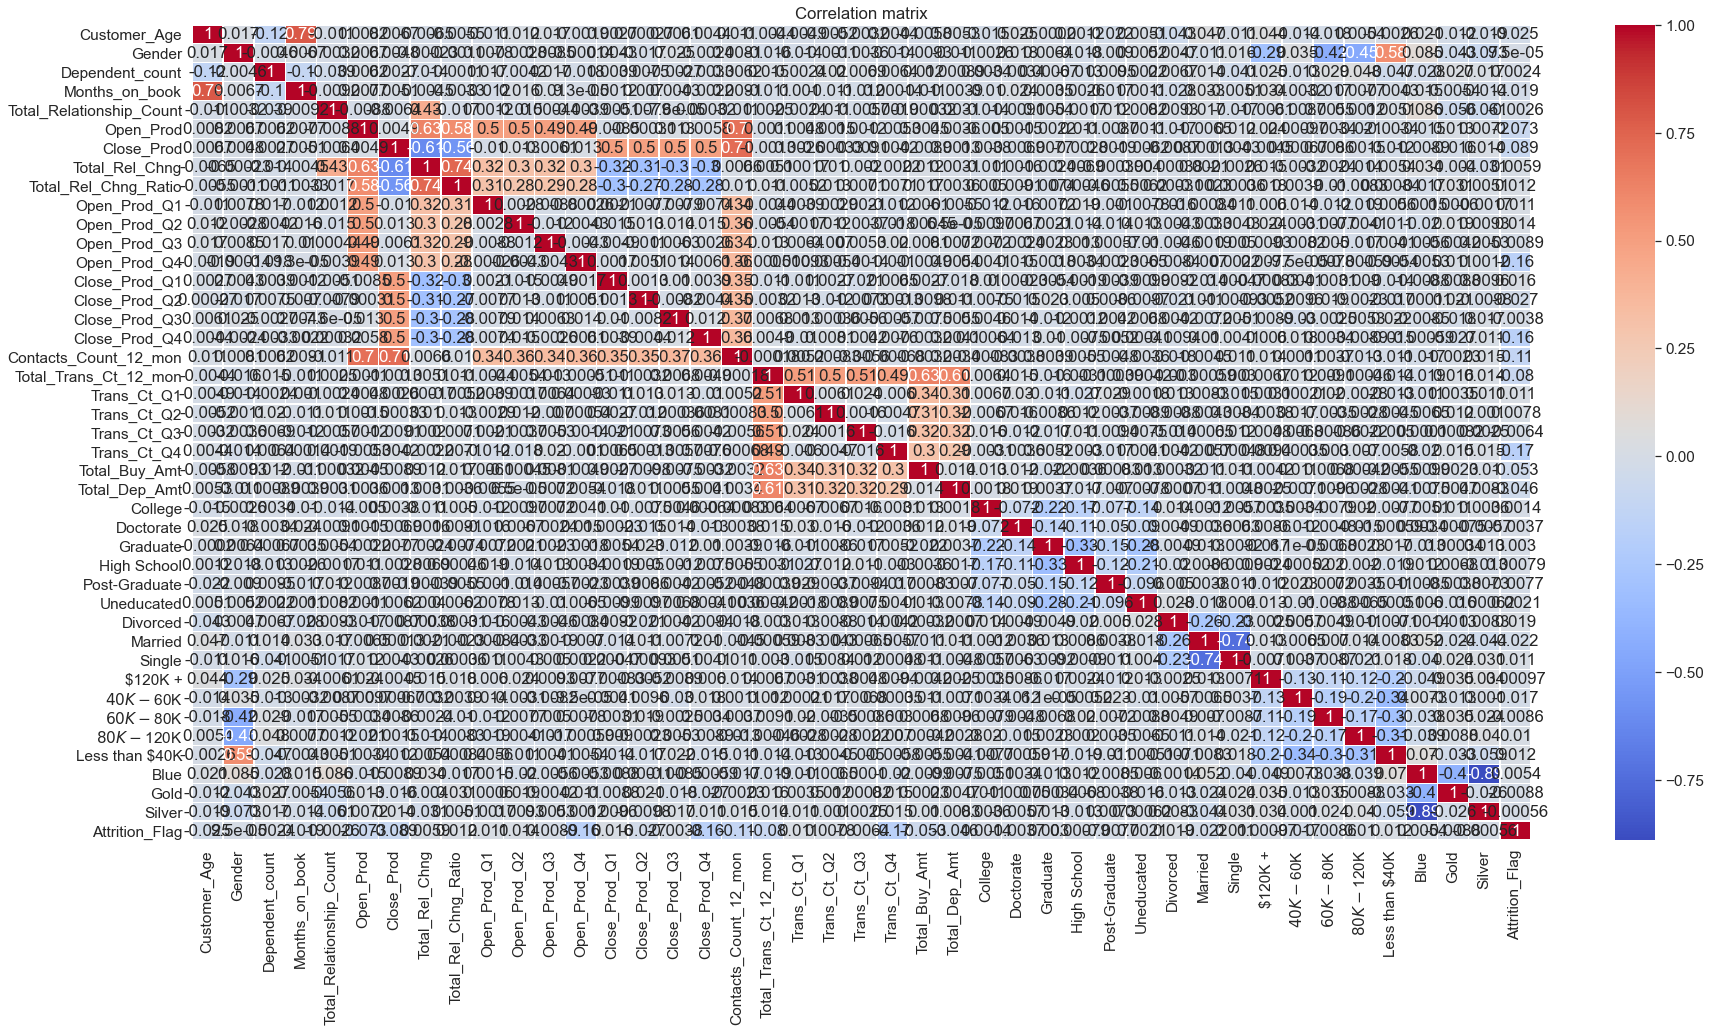

In [14]:
plt.figure(figsize = (30, 15))

sns.set(font_scale=1.4)
sns.heatmap(c_data.corr(), annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Из матрицы видно, что есть несколько признаков с повышенной кореляцией, но пока оставим их

Посмотрим на разброс количества действующих клиентов и ушедших

In [15]:
Counter(c_data['Attrition_Flag'])

Counter({0: 9923, 1: 204})

Необходимо использовать балансировку классов

## Построение модели

Разобьем датасет на тренировочный и тестовый, произведем балансировку классов

In [16]:
X = c_data.drop(['Attrition_Flag'], axis=1)
y = c_data['Attrition_Flag']

# Нормализация данных
mms = MinMaxScaler()
X_mm = mms.fit_transform(X)

In [17]:
# Разобьем датасет на тренировоный и тестовый
X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=42)

In [18]:
# Балансировка классов
X_train_balanced, y_train_balanced = SMOTE(sampling_strategy=0.3, random_state=42, n_jobs=-1).fit_resample(X_train, y_train)

In [19]:
# Просмотр результатов
print('До:', Counter(y_train))
print('После:', Counter(y_train_balanced))

До: Counter({0: 6945, 1: 143})
После: Counter({0: 6945, 1: 2083})


Напишем функции для вычисления качества работы модели

In [20]:
# Функция вычисляющая метрики качества модели
def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Метрики модели:')
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll))
    print('ROC AUC: {}'.format(roc_auc))
    return precision, recall, f1, ll, roc_auc


# Функция обучения модели и ее предсказания
def lgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = lgb.LGBMClassifier(max_depth=4,
                             n_estimators=550,
                             learning_rate=0.01,
                             n_jobs=-1,
                             subsample=1.,
                             colsample_bytree=0.5,
                             min_child_weight=3,
                             reg_alpha=0.,
                             reg_lambda=0.,
                             seed=42)
    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf


# Функция отрисовки важности признаков
def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

Обучение модели

In [21]:
model = lgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Метрики модели:
Precision: 1.0
Recall: 1.0
F1: 1.0
Log Loss: 0.009230028803000235
ROC AUC: 1.0


Проведем отбор признаков

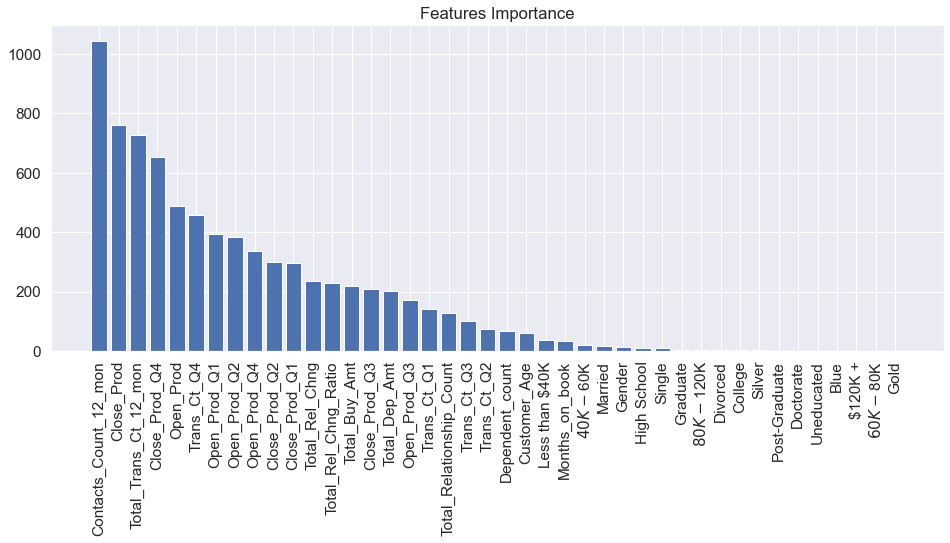

In [22]:
feature_importance = plot_importance(model.feature_importances_, X.columns, 'Features Importance')

In [23]:
# Оставим часть значимых признаков
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:24]]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:24]]

model = lgb_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Метрики модели:
Precision: 1.0
Recall: 1.0
F1: 1.0
Log Loss: 0.01016259970557613
ROC AUC: 1.0
Признаков было: 42
Признаков стало: 24


Видим, что признаков стало меньше, а качество практически не изменилось

Построим матрицу ошибок, из которой нам будет видно насколько наша модель корректно определила ушедших клиентов

In [24]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    cm = np.array([[TP, FP],
                   [FN, TN]])
    cm_normalized = cm.astype('float') / cm.sum(axis=0)
    # Plot both matrixes - basic and normalized
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    for ax, normalize, data, title in zip(ax,
                                          [False, True], 
                                          [cm, cm_normalized], 
                                          ['Confusion matrix (without normalization)', 
                                           'Сonfusion matrix (normalized)']):
        im = ax.imshow(data, interpolation='nearest', cmap=cmap)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax)
        ax.set(xticks=np.arange(data.shape[1]),
               yticks=np.arange(data.shape[0]),
               xticklabels=classes, 
               yticklabels=classes,
               title=title,
               ylabel='Predicted label',
               xlabel='True label')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')        
        # Loop over data dimensions and create text annotations
        fmt = '.2f' if normalize else 'd'
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, format(data[i, j], fmt), ha="center", va="center", 
                        color="white" if data[i, j] > data.max() / 2. else "black")                
    fig.tight_layout()
    return fig 

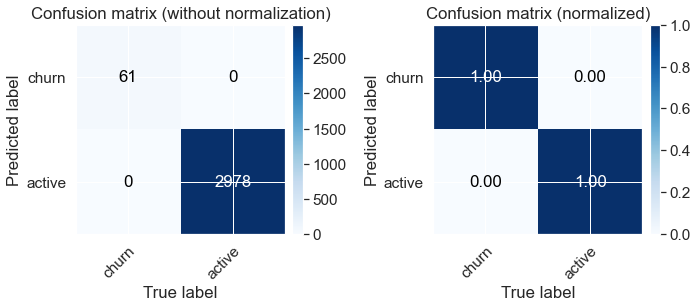

In [25]:
predict_test = model.predict(X_test_FI)

plot_confusion_matrix(y_test.values, predict_test, classes=['churn', 'active'])
plt.show()